In [1]:
from google.colab import drive
drive.mount('/content/gdrive', timeout_ms=60000)
from PIL import Image
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
import keras.preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.applications import InceptionV3

Mounted at /content/gdrive


**Load data**

In [2]:
dataPath = "/content/gdrive/MyDrive/FireDataset/fire_dataset"

# List all files in the dataset directory
file_list = [os.path.join(dataPath, file) for file in os.listdir(dataPath)]

# Assuming you have subdirectories for classes, if not, adjust accordingly
class_folders = [folder for folder in file_list if os.path.isdir(folder)]

# Initialize lists to store file paths for each class
all_files = []

# Populate the list with file paths
for cls_folder in class_folders:
    all_files.extend([os.path.join(cls_folder, file) for file in os.listdir(cls_folder)])

# Split the dataset into training and testing sets
train_files, test_files = train_test_split(all_files, test_size=0.2)

# Create temporary directories for organizing files
temp_train_dir = "/content/trainFire"
temp_test_dir = "/content/testFire"

# Create class directories in temporary train and test directories
for class_folder in class_folders:
    os.makedirs(os.path.join(temp_train_dir, os.path.basename(class_folder)), exist_ok=True)
    os.makedirs(os.path.join(temp_test_dir, os.path.basename(class_folder)), exist_ok=True)

# Move files to temporary train and test directories based on their class labels
for file in train_files:
    shutil.copy(file, os.path.join(temp_train_dir, os.path.basename(os.path.dirname(file))))

for file in test_files:
    shutil.copy(file, os.path.join(temp_test_dir, os.path.basename(os.path.dirname(file))))


In [57]:
files = os.listdir('/content/trainFire/fire_images')
file = os.listdir("/content/trainFire/non_fire_images")
print(len(files)," ", len(file))


596   203


**preprocessing the data**

In [3]:
# Define the directory paths for the training and testing datasets
dataTrain = "/content/trainFire"
dataTest = "/content/testFire"

# Create an ImageDataGenerator for training and testing data
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Rescale pixel values to the range [0, 1]
    horizontal_flip=True,           # Randomly flip images horizontally
    rotation_range=30,               # Randomly rotate images within the range [-30, 30] degrees
    height_shift_range=0.2,          # Randomly shift the height of images by a fraction of total height
    fill_mode='nearest'              # Fill in newly created pixels after rotation or shifting
)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
target_size = (150, 150)# Define the target size

# Create a generator for loading training and testing images
train_generator = train_datagen.flow_from_directory(
    dataTrain,                      # Directory containing the training images
    batch_size=64,                  # Number of images to include in each batch
    class_mode='binary',            # Type of labels to return (binary for binary classification)
    target_size=target_size         # Resize images to the specified target size
)
validation_generator = test_datagen.flow_from_directory(
    dataTest,
    batch_size=64,
    class_mode='binary',
    target_size=target_size
)

Found 799 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


**Training**

In [4]:
# Load the InceptionV3 model pre-trained on ImageNet, excluding the top classification layer
base_InceptionV3_model = InceptionV3(input_shape=[150, 150, 3], include_top=False, weights="imagenet")
# Freeze the layers in the base model so they are not trainable
for layer in base_InceptionV3_model.layers:
    layer.trainable = False
# Create a new Sequential model for adding custom layers on top of the InceptionV3 base
InceptionV3_model = Sequential()
InceptionV3_model.add(base_InceptionV3_model)
InceptionV3_model.add(GlobalAveragePooling2D())
InceptionV3_model.add(Dropout(0.2))
InceptionV3_model.add(Dense(512))
InceptionV3_model.add(Dropout(0.2))
InceptionV3_model.add(Dense(1, activation="sigmoid"))

# Compile the model with Adam optimizer, binary cross-entropy loss function, and accuracy metric
InceptionV3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

87910968/87910968 [==============================] - 1s 0us/step


In [5]:
# Train the compiled model using the training generator and validate it using the validation generator for 10 epochs
Model = InceptionV3_model.fit(train_generator, validation_data = validation_generator, verbose=1, epochs=10)

Epoch 1/10
13/13 [==============================] - 85s 6s/step - loss: 2.9035 - acc: 0.7685 - val_loss: 0.5128 - val_acc: 0.9350
Epoch 2/10
13/13 [==============================] - 77s 6s/step - loss: 0.6530 - acc: 0.9149 - val_loss: 0.3689 - val_acc: 0.9650
Epoch 3/10
13/13 [==============================] - 73s 6s/step - loss: 0.3156 - acc: 0.9549 - val_loss: 0.3216 - val_acc: 0.9700
Epoch 4/10
13/13 [==============================] - 69s 5s/step - loss: 0.3555 - acc: 0.9549 - val_loss: 0.2839 - val_acc: 0.9800
Epoch 5/10
13/13 [==============================] - 68s 5s/step - loss: 0.3506 - acc: 0.9512 - val_loss: 0.3552 - val_acc: 0.9600
Epoch 6/10
13/13 [==============================] - 74s 6s/step - loss: 0.2055 - acc: 0.9587 - val_loss: 0.2713 - val_acc: 0.9700
Epoch 7/10
13/13 [==============================] - 75s 6s/step - loss: 0.2231 - acc: 0.9612 - val_loss: 0.2960 - val_acc: 0.9600
Epoch 8/10
13/13 [==============================] - 77s 6s/step - loss: 0.1291 - acc: 0.97

**Plotting the Accuracy and Loss**

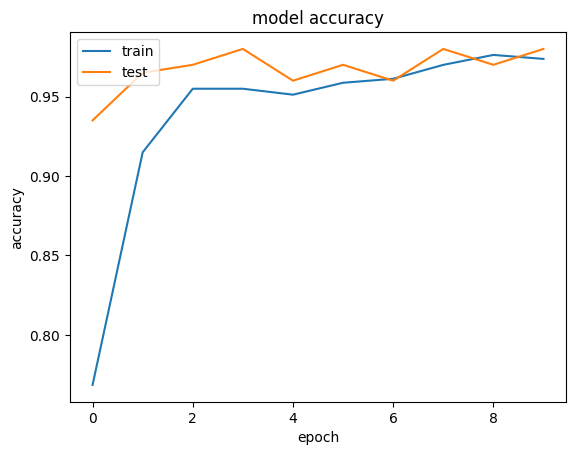

In [6]:
plt.plot(Model.history['acc'])
plt.plot(Model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

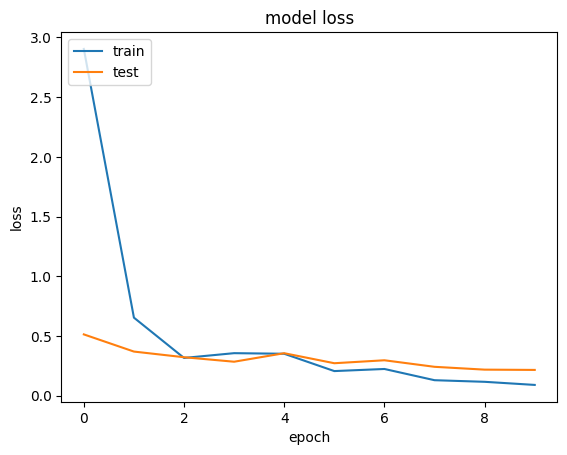

In [7]:
plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Testing**

In [8]:
InceptionV3_model.save("inceptionv3_trained_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Load the best model
Model = tf.keras.models.load_model("/content/inceptionv3_trained_model.h5")

In [47]:
def predict(path):
  # Load and preprocess the test image(s)
  img = image.load_img(path, target_size=(150, 150))  # Resize image to match model input size
  img_array = image.img_to_array(img)  # Convert image to numpy array
  img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
  img_array /= 255.0  # Normalize pixel values (assuming the model was trained with rescaling)

  # Make predictions
  predictions = Model.predict(img_array)
  # Interpret the predictions
  # {'fire_images': 0, 'non_fire_images': 1}
  class_label = "no fire" if predictions[0][0] >= 0.5 else "fire"
  confidence = predictions[0][0] if predictions[0][0] >= 0.5 else 1 - predictions[0][0]
  # Display the test image with the predicted class
  plt.imshow(img)
  plt.title(f"Predicted class: {class_label}\nConfidence: {confidence:.2f}")
  plt.axis('off')
  plt.show()


1/1 [==============================] - 0s 80ms/step


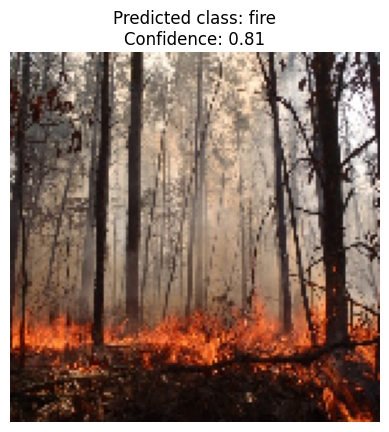

1/1 [==============================] - 0s 93ms/step


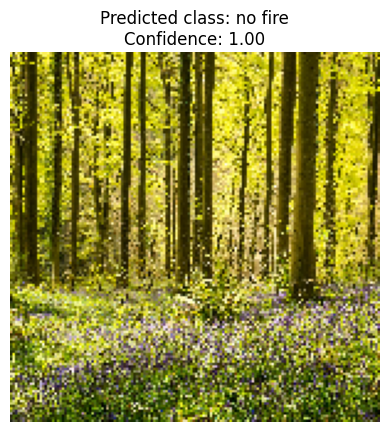

In [59]:
predict("/content/testFire/fire_images/fire.10.png")
predict("/content/testFire/non_fire_images/non_fire.105.png")